

Steps:

-  Initialize the pretrained model
-  Reshape the final layer(s) to have the same number of outputs as the
   number of classes in the new dataset
-  Define for the optimization algorithm which parameters we want to
   update during training
-  Run the training step




In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  2.0.1+cu118
Torchvision Version:  0.15.2+cu118


Inputs
------


 ``feature_extract`` is a boolean that defines if we are finetuning
or feature extracting.

If ``feature_extract = False``, the model is
finetuned and all model parameters are updated.

If ``feature_extract = True``, only the last layer parameters are updated,
the others remain fixed.




# Connect

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


#Config

In [3]:
class config:
  images_path = '/content/gdrive/MyDrive/licenta/dataset/poze'
  train_file_path = '/content/gdrive/MyDrive/licenta/dataset/train.txt'
  val_file_path = '/content/gdrive/MyDrive/licenta/dataset/validare.txt'
  test_file_path = '/content/gdrive/MyDrive/licenta/dataset/test.txt'
  save_path ='/content/gdrive/MyDrive/licenta/model_vgg16.pt'
  save_path_scratch ='/content/gdrive/MyDrive/licenta/model_vgg16_scratch.pt'
  BATCH_SIZE = 8
  EPOCHS = 15
  PRE_TRAINED_MODEL_NAME = "vgg16"
  DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
data_dir = config.images_path
num_classes = 7
feature_extract = False

# Train Function



In [5]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=config.EPOCHS):
    since = time.time()

    val_history = {'val_acc':[], 'val_loss':[]}
    train_history = {'train_acc':[], 'train_loss':[]}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(config.DEVICE)
                labels = labels.to(config.DEVICE)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), config.save_path)
            if phase == 'val':
                val_history['val_acc'].append(epoch_acc)
                val_history['val_loss'].append(epoch_loss)
            else:
                train_history['train_acc'].append(epoch_acc)
                train_history['train_loss'].append(epoch_loss)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, val_history, train_history

In [7]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

Since  the model has been pretrained on
Imagenet, it has the output layers of size 1000, one node for each
class.

The goal here is to reshape the last layer to have the same
number of inputs as before, AND to have the same number of outputs as
the number of classes in the dataset.


When feature extracting, we only want to update the parameters of the
last layer, or in other words, we only want to update the parameters for
the layer(s) we are reshaping.

Therefore, we do not need to compute the
gradients of the parameters that we are not changing, so for efficiency
we set the .requires_grad attribute to False.

This is important because by default, this attribute is set to True. Then, when we initialize the new layer and by default the new parameters have ``.requires_grad=True`` so only the new layer’s parameters will be updated. When we are finetuning we can leave all of the .required_grad’s set to the default
of True.


**VGG**

VGG was introduced in the paper `Very Deep Convolutional Networks for
Large-Scale Image Recognition <https://arxiv.org/pdf/1409.1556.pdf>`.
Torchvision offers eight versions of VGG with various lengths and some
that have batch normalizations layers. Here we use VGG-11 with batch
normalization. The output layer is

   (classifier): Sequential(
       ...
       (6): Linear(in_features=4096, out_features=1000, bias=True)
    )

In [8]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    input_size = 0
    if model_name == "vgg11":
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
    elif model_name == "vgg16":
        model_ft = models.vgg16_bn(pretrained=use_pretrained)
    elif model_name == "vgg19":
        model_ft = models.vgg19_bn(pretrained=use_pretrained)
    else:
        print("Invalid model name...")
        exit()
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
    input_size = 224

    return model_ft, input_size

model_ft, input_size = initialize_model(config.PRE_TRAINED_MODEL_NAME, num_classes, feature_extract, use_pretrained=True)

print(model_ft)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [9]:
config.PRE_TRAINED_MODEL_NAME

'vgg16'

Load Data
---------





In [10]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=config.BATCH_SIZE, shuffle=True, num_workers=4) for x in ['train', 'val']}


Initializing Datasets and Dataloaders...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Create the Optimizer
--------------------




In [11]:
model_ft = model_ft.to(config.DEVICE)
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 features.0.weight
	 features.0.bias
	 features.1.weight
	 features.1.bias
	 features.3.weight
	 features.3.bias
	 features.4.weight
	 features.4.bias
	 features.7.weight
	 features.7.bias
	 features.8.weight
	 features.8.bias
	 features.10.weight
	 features.10.bias
	 features.11.weight
	 features.11.bias
	 features.14.weight
	 features.14.bias
	 features.15.weight
	 features.15.bias
	 features.17.weight
	 features.17.bias
	 features.18.weight
	 features.18.bias
	 features.20.weight
	 features.20.bias
	 features.21.weight
	 features.21.bias
	 features.24.weight
	 features.24.bias
	 features.25.weight
	 features.25.bias
	 features.27.weight
	 features.27.bias
	 features.28.weight
	 features.28.bias
	 features.30.weight
	 features.30.bias
	 features.31.weight
	 features.31.bias
	 features.34.weight
	 features.34.bias
	 features.35.weight
	 features.35.bias
	 features.37.weight
	 features.37.bias
	 features.38.weight
	 features.38.bias
	 features.40.weight
	 features.40.

Run Training and Validation Step
--------------------------------






In [12]:
criterion = nn.CrossEntropyLoss()
model_ft,  val_history, train_history = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=config.EPOCHS)

Epoch 0/14
----------
train Loss: 1.3568 Acc: 0.4985
val Loss: 1.2268 Acc: 0.5946

Epoch 1/14
----------
train Loss: 1.1350 Acc: 0.5870
val Loss: 0.7985 Acc: 0.7282

Epoch 2/14
----------
train Loss: 1.0300 Acc: 0.6357
val Loss: 0.9989 Acc: 0.6585

Epoch 3/14
----------
train Loss: 0.9697 Acc: 0.6508
val Loss: 0.7778 Acc: 0.7317

Epoch 4/14
----------
train Loss: 0.9244 Acc: 0.6629
val Loss: 0.7085 Acc: 0.7598

Epoch 5/14
----------
train Loss: 0.8804 Acc: 0.6851
val Loss: 0.6683 Acc: 0.7727

Epoch 6/14
----------
train Loss: 0.8437 Acc: 0.6970
val Loss: 0.7096 Acc: 0.7586

Epoch 7/14
----------
train Loss: 0.8315 Acc: 0.7000
val Loss: 0.6977 Acc: 0.7487

Epoch 8/14
----------
train Loss: 0.8009 Acc: 0.7118
val Loss: 0.6152 Acc: 0.7938

Epoch 9/14
----------
train Loss: 0.7884 Acc: 0.7131
val Loss: 0.6468 Acc: 0.7750

Epoch 10/14
----------
train Loss: 0.7513 Acc: 0.7302
val Loss: 0.6417 Acc: 0.7879

Epoch 11/14
----------
train Loss: 0.7540 Acc: 0.7258
val Loss: 0.6481 Acc: 0.7920

Ep

Visualize the performance
------------------------------------------

In [13]:
val_history, train_history

({'val_acc': [tensor(0.5946, device='cuda:0', dtype=torch.float64),
   tensor(0.7282, device='cuda:0', dtype=torch.float64),
   tensor(0.6585, device='cuda:0', dtype=torch.float64),
   tensor(0.7317, device='cuda:0', dtype=torch.float64),
   tensor(0.7598, device='cuda:0', dtype=torch.float64),
   tensor(0.7727, device='cuda:0', dtype=torch.float64),
   tensor(0.7586, device='cuda:0', dtype=torch.float64),
   tensor(0.7487, device='cuda:0', dtype=torch.float64),
   tensor(0.7938, device='cuda:0', dtype=torch.float64),
   tensor(0.7750, device='cuda:0', dtype=torch.float64),
   tensor(0.7879, device='cuda:0', dtype=torch.float64),
   tensor(0.7920, device='cuda:0', dtype=torch.float64),
   tensor(0.7914, device='cuda:0', dtype=torch.float64),
   tensor(0.8166, device='cuda:0', dtype=torch.float64),
   tensor(0.7903, device='cuda:0', dtype=torch.float64)],
  'val_loss': [1.226801328225728,
   0.7985047732414945,
   0.9989425779157168,
   0.7778147011995316,
   0.7085057422125906,
   0.66

In [17]:
def transform_history(instance):
  instance = instance.item()
  return instance

val_acc_history = list(map(transform_history, val_history['val_acc']))
train_acc_history = list(map(transform_history, train_history['train_acc']))

In [16]:
val_acc_history = list(map(transform_history, val_history['val_acc']))
train_acc_history = list(map(transform_history, train_history['train_acc']))

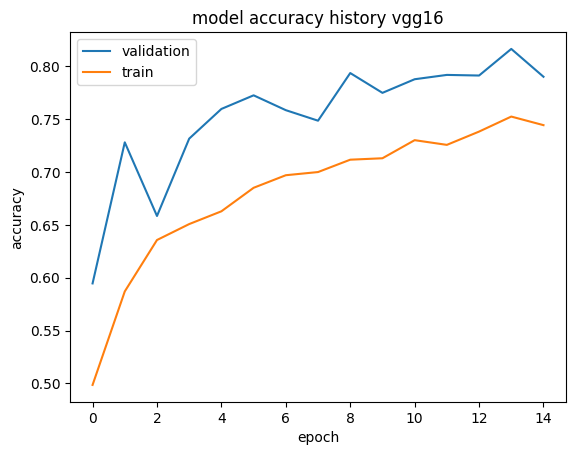

In [18]:
# summarize history for accuracy
plt.plot(val_acc_history)
plt.plot(train_acc_history)
plt.title('model accuracy history vgg16')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['validation', 'train'], loc='upper left')
plt.show()

In [19]:
val_history['val_loss'][0]

1.226801328225728

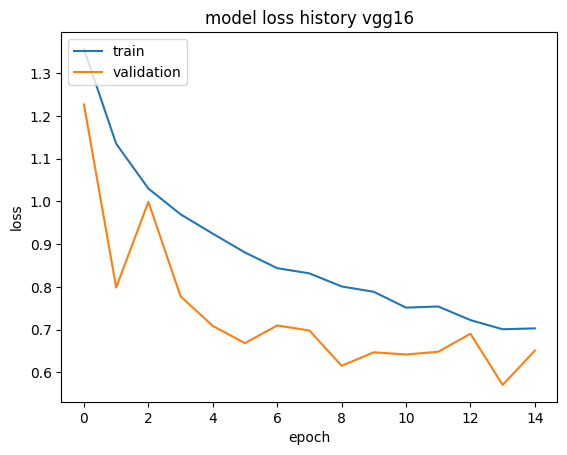

In [20]:
# summarize history for loss
plt.plot(train_history['train_loss'])
plt.plot(val_history['val_loss'])
plt.title('model loss history vgg16')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Test model

In [21]:
model_ft

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [22]:
data_transforms_test = {
    'test': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

print("Initializing Datasets and Dataloaders...")

image_test_datasets = datasets.ImageFolder(root = os.path.join(data_dir,'test'),transform=data_transforms_test['test'])
dataloaders_test_dict = torch.utils.data.DataLoader(image_test_datasets, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=4)

Initializing Datasets and Dataloaders...


In [23]:
dataloaders_test_dict.dataset

Dataset ImageFolder
    Number of datapoints: 3068
    Root location: /content/gdrive/MyDrive/licenta/dataset/poze/test
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [24]:
len(dataloaders_test_dict)*config.BATCH_SIZE

3072

In [25]:
def test_model(model, dataloader):
    since = time.time()
    model.eval()

    running_corrects = 0

    for inputs, labels in dataloader:
        inputs = inputs.to(config.DEVICE)
        labels = labels.to(config.DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)

            _, preds = torch.max(outputs, 1)

            running_corrects += torch.sum(preds == labels.data)

    acc = running_corrects.double() / len(dataloader.dataset)
    time_elapsed = time.time() - since
    print('Test complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Overall Acc: {:4f}'.format(acc))

    return acc

In [26]:
test_acc = test_model(model_ft,dataloaders_test_dict)

Test complete in 9m 46s
Overall Acc: 0.717080


In [27]:
test_acc.item()

0.7170795306388527

# Train the model from scratch for comparison

In [ ]:
scratch_model,_ = initialize_model(config.PRE_TRAINED_MODEL_NAME, num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(config.DEVICE)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
scratch_model,  scratch_val_history, scratch_train_history= train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=config.EPOCHS)

In [ ]:
scratch_model,  scratch_val_history, scratch_train_history

In [ ]:
val_acc_history_scratch = list(map(transform_history, scratch_val_history['val_acc']))
train_acc_history_scratch = list(map(transform_history, scratch_train_history['train_acc']))

In [ ]:
# summarize history for accuracy
plt.plot(val_acc_history_scratch)
plt.plot(train_acc_history_scratch)
plt.title('model accuracy history vgg16 from scratch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['validation', 'train'], loc='upper left')
plt.show()

In [ ]:
# summarize history for loss
plt.plot(scratch_train_history['train_loss'])
plt.plot(scratch_val_history['val_loss'])
plt.title('model loss history vgg16 from scratch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
test_acc = test_model(scratch_model,dataloaders_test_dict)
test_acc.item()